HillClimbMABCallback : A hybrid MAB controller that combines stable hill-climbing with global exploration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image
import wandb # or just save the image if you're not using wandb

In [8]:
from callbacks.plots import plot_trajectory_2d

 

In [10]:

def plot_trajectory_2d(episodes, snd, returns, target_diversity=None):
    """
    Generates a single 2D line chart plotting SND and Mean Return trajectory.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot Actual Trajectory
    ax.plot(snd, returns, c='b', marker='o', label='Actual Trajectory')

    # Add text annotations for episode numbers to show the time progression
    for i, ep in enumerate(episodes):
        ax.annotate(f'Ep: {ep}', (snd[i], returns[i]), fontsize=8, ha='right')

    # Plot Target Diversity Trajectory if available
    if target_diversity is not None and len(target_diversity) == len(episodes):
        ax.plot(target_diversity, returns, c='r', marker='x', linestyle='--', label='Target Diversity Trajectory')
    
    # Set labels, title, and legend
    ax.set_xlabel('SND (Behavioral Distance)')
    ax.set_ylabel('Mean Return')
    ax.set_title('Trajectory of Mean Return vs. SND')
    ax.legend()
    ax.grid(True)

    plt.show()


In [ ]:
import pandas as pd

file_path = '/home/grad/doc/2027/spatel2/MARL-UAV/Saved Run Tables/trajectory_data_initial_snd_0.50.csv' 

try:
    df = pd.read_csv(file_path)
    print("CSV loaded successfully!")
    print(df.shape)
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")
    df = None

CSV loaded successfully!
(31, 5)


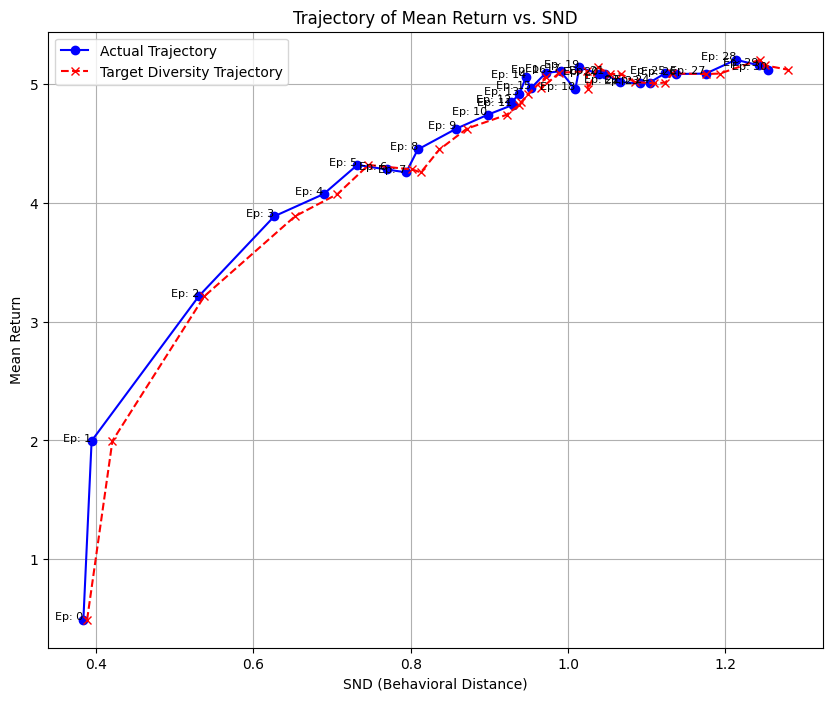

In [ ]:
if df is not None:
    # Get the data from the DataFrame columns
    episodes = df['episode_number']
    snd = df['actual_snd']
    returns = df['reward']
    
    if 'target_snd' in df.columns:
        target_diversity = df['target_snd']
    else:
        target_diversity = None
        
    # Plot the trajectory
    plot_trajectory_2d(episodes, snd, returns, target_diversity)

In [ ]:
# Extremum Seeking Controller

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
#ES function
#this variation includes low pass filtering of the gradient estimate

def es_function_lpf(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1):
    
    #outputs:
    #uk: the control to be applied at the next timestep
    #uhatk: the output of the integrator
    #gammak: the output of the lowpass filter
    #psik: signal after demodulation (mutliplication by cosine)
    #sigmak: the output of the washout (highpass) filter
    
    #inputs:
    #Jk, Jkm1: values of the objective function (metric we're optimizing) at the present and last timestep
    #sigmakm1: output of highpass filter at last timestep
    #psikm1: signal after demodulation at last timestep
    #gammakm1: output of lowpass filter 
    #uhatkm1: output of integrator at last timestep
    #t: present time at this timestep
    #T: distance between timesteps, delta_T
    #hpf: high pass filter gain, usually make this an order of magnitude lower than w
    #lpf: low pass filter gain, usually make this equal to hpf, but I usually end up adjusting this quite a bit
    #c: gain on the integrator - how much to value new measurements compared to old measurements
    #ak: the amplitude of the probing signal

    #calculate angular frequency:
    w = 2*np.pi*f

    #extract the effect of the probing signal in the objective function
    #do this by passing the signal through a highpass filter
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)
    #print("sigma: ", sigmak)

    #the resulting signal is a sinusoid, multiply by a sinusoid of the same frequency
    #this results in a cos**2 term, that has a DC component (we call this demodulation)
    psik = sigmak*np.cos(w*t)
    
    #pass the demodulated signal through a lowpass filter, to eliminate noise and "jumpiness"
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    #pass the resulting signal through an integrator - this approximates a gradient descent
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    #modulation - add the perturbation to the next control setpoint
    uk = (uhatk + a_param*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk)



program running
program complete


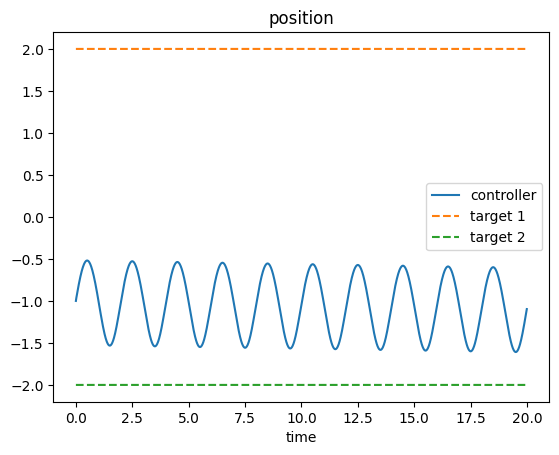

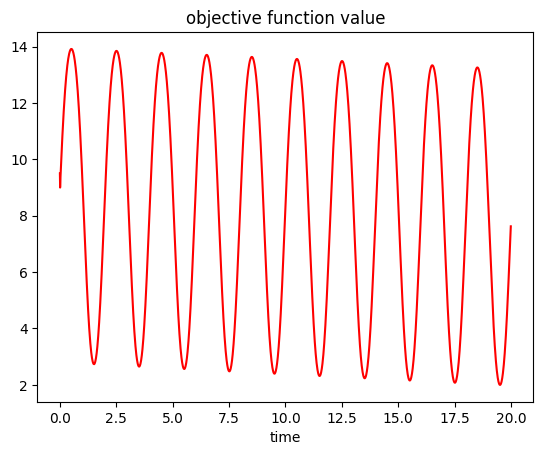

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# A simplified, placeholder es_function_lpf based on standard ES logic.
def es_function_lpf(time, T, hpf, lpf, f, c, a, J_current, J_prev, sigma_prev, psi_prev, gamma_prev, uhat_prev):
    probe = a * np.sin(2 * np.pi * f * time)
    
    # 1. High-pass filter (simulated by a difference)
    sigma = J_current - J_prev
    
    # 2. Demodulation
    psi = sigma * np.sin(2 * np.pi * f * time)
    
    # 3. Low-pass filter (simulated by a simple average)
    gamma = (psi + psi_prev) / 2
    
    # 4. Integrator
    uhat = uhat_prev + c * gamma * T
    
    # 5. Controller output with probe
    uk = uhat + probe
    
    return uk, sigma, psi, gamma, uhat

# Simulation
# The goal of this experiment is to minimize a quartic function with two minima
# The initial value of the controller, u, is the starting position

# setup time
T = 0.01  # delta T: the length of each timestep
time = np.arange(0., 2000.)
time = time * T

# setup vectors to store past values of the ES control
J = np.zeros(len(time))  # objective function
sigma = np.zeros(len(time))  # value after highpass (washout) filter
psi = np.zeros(len(time))  # value after demodulation
gamma = np.zeros(len(time))  # value after lowpass filter
uhat = np.zeros(len(time))  # value after integration
u = np.zeros(len(time))  # control outputs of ES control (position)

# initial conditions
u[0] =-1  # We choose an initial condition that will converge to the minimum at u=2
# u_target = 10 # This is no longer the single target value
J[0] = (u[0]**2 - 4)**2 + 0.5  # New objective function with two solutions
sigma[0] = u[0]
psi[0] = u[0]
gamma[0] = u[0]
uhat[0] = u[0]

# setup parameters for the ES controller
f = 0.5 # frequency of probe, in Hz
c = -1  # gain on the integrator
lpf = 1  # lowpass filter critical frequency
hpf = 1  # highpass filter critical frequency
a = 0.5  # amplitude of the probe

print("program running")

for i in range(0, len(time)):
    
    if (i >= 1):
        # evaluate objective function value
        # This is a quartic function with two minima at u = 2 and u = -2
        J[i] = (u[i-1]**2 - 4)**2
        
        # call the ES controller - low pass filter
        uk, sigmak, psik, gammak, uhatk = es_function_lpf(time[i], T, hpf, lpf, f, c, a, J[i], J[i-1], \
            sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1])
        
        # store values for next timestep
        u[i] = uk
        sigma[i] = sigmak
        psi[i] = psik
        gamma[i] = gammak
        uhat[i] = uhatk

print("program complete")

# Plotting with two potential targets
target1 = np.ones(len(u)) * 2
target2 = np.ones(len(u)) * -2

fig1 = plt.figure(1)
plt.plot(time, u, label="controller")
plt.plot(time, target1, '--', label="target 1")
plt.plot(time, target2, '--', label="target 2")
plt.title('position')
plt.xlabel('time')
plt.legend()
fig1.savefig('ES_two_solutions.png')

plt.figure(2)
plt.plot(time, J, 'r')
plt.title('objective function value')
plt.xlabel('time')

plt.show()

In [9]:
# Adaptive Version of the ESC controller

In [6]:
%matplotlib inline

In [11]:

def es_function(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, akm1, lpf_a):
    
    #outputs:
    #uk: the control to be applied at the next timestep
    #uhatk: the output of the integrator
    #gammak: the output of the lowpass filter
    #psik: signal after demodulation (mutliplication by cosine)
    #sigmak: the output of the washout (highpass) filter
    
    #inputs:
    #Jk, Jkm1: values of the objective function (metric we're optimizing) at the present and last timestep
    #sigmakm1: output of highpass filter at last timestep
    #psikm1: signal after demodulation at last timestep
    #gammakm1: output of lowpass filter 
    #uhatkm1: output of integrator at last timestep
    #t: present time at this timestep
    #T: distance between timesteps, delta_T
    #hpf: high pass filter gain, usually make this an order of magnitude lower than w
    #lpf: low pass filter gain, usually make this equal to hpf, but I usually end up adjusting this quite a bit
    #c: gain on the integrator - how much to value new measurements compared to old measurements
    #ak: the amplitude of the probing signal

    #calculate angular frequency:
    w = 2*np.pi*f

    #extract the effect of the probing signal in the objective function
    #do this by passing the signal through a highpass filter
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)

    #the resulting signal is a sinusoid, multiply by a sinusoid of the same frequency
    #this results in a cos**2 term, that has a DC component (we call this demodulation)
    psik = sigmak*np.cos(w*t)

    #pass the demodulated signal through a lowpass filter, to eliminate noise and "jumpiness"
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)
    
    #probe amplitude adaptation
    ak = a_param * (T*lpf_a*( (np.arctan(psik) / np.pi * 2 )**2 + (np.arctan(psikm1) / np.pi * 2)**2)) - (T*lpf_a - 2)*akm1/(2 + T*lpf_a)

    #pass the resulting signal through an integrator - this approximates a gradient descent
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    #modulation - add the perturbation to the next control setpoint
    uk = (uhatk + ak*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk, ak)

In [24]:
# Simulation

# setup time
T = 0.01 
time = []
time.append(0)

# setup vectors to store past values of the ES control
J = [] 
sigma = [] 
psi = [] 
gamma = [] 
uhat = [] 
u = []  
a = [] 

# initial conditions
u0 = 2 
u_target = 10

# Initialize all state vectors to zero
J.append( (((u0 - u_target) / u_target)**2)/1 )
sigma.append(0)
psi.append(0)
gamma.append(0)
uhat.append(u0)
a0 = 0.5 
a.append(a0)

# setup parameters for the ES controller
f = 1 # frequency of probe, in Hz
c = -1 # gain on the integrator (negative for minimization)
lpf = 0.1 # lowpass filter critical frequency (much lower than f)
hpf = 0.1 # highpass filter critical frequency (much lower than f)
lpf_a = 0.1

delta = 10
epsilon = 1e-5

print("program running")
i = 0
while(delta >= epsilon):
    
    if(i>=1):
        # evaluate objective function value
        J.append( (((u[i-1] - u_target) / u_target)**2 )/1 )
        
        # call the ES controller
        uk, sigmak, psik, gammak, uhatk, ak = es_function(time[i], T, hpf, lpf, f, c, a[i-1], J[i], J[i-1], \
            sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1])

        # store values for next timestep
        u.append(uk)
        sigma.append(sigmak)
        psi.append(psik)
        gamma.append(gammak)
        uhat.append(uhatk)
        a.append(ak)
        
        delta = np.abs(u[i] - u[i-1]) + np.abs(a[i] - a[i-1])
    
    time.append(time[i] + T)
    i+=1

print("program complete, number of iterations:", i)
time.pop()

# Plot Results
target = np.ones(len(u))*u_target

fig1 = plt.figure(1)
plt.plot(time, u, label="controller")
plt.plot(time, target, '--', label="target")
plt.title('position')
plt.xlabel('time')
plt.legend()
fig1.savefig('ES_basic.png')

plt.figure(2)
plt.plot(time, J, 'r', label="objective function")
plt.title('objective function value')
plt.plot(time, np.zeros(len(u)), '--', label="target")
plt.xlabel('time')
plt.legend()

plt.figure(3)
plt.plot(time, a, 'g')
plt.xlabel('time')
plt.title('Probe Amplitude')

plt.show()



program running


IndexError: list index out of range

program running
program complete, number of iterations: 32601


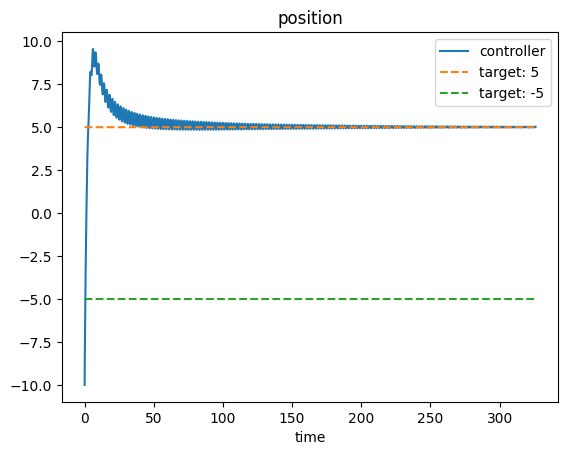

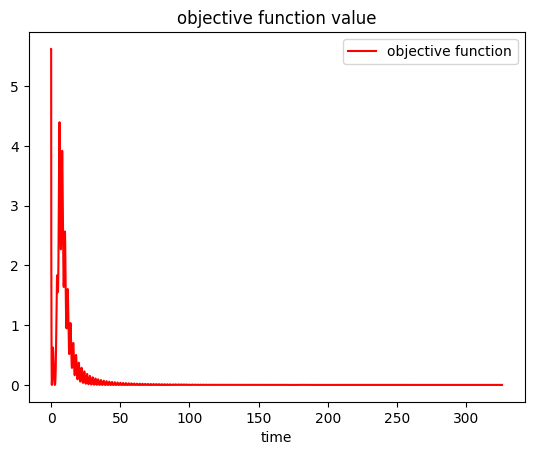

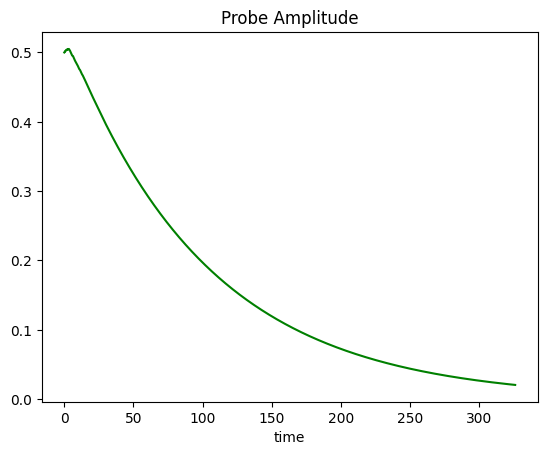

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def es_function(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, akm1, lpf_a):
    
    #outputs:
    #uk: the control to be applied at the next timestep
    #uhatk: the output of the integrator
    #gammak: the output of the lowpass filter
    #psik: signal after demodulation (mutliplication by cosine)
    #sigmak: the output of the washout (highpass) filter
    
    #inputs:
    #Jk, Jkm1: values of the objective function (metric we're optimizing) at the present and last timestep
    #sigmakm1: output of highpass filter at last timestep
    #psikm1: signal after demodulation at last timestep
    #gammakm1: output of lowpass filter 
    #uhatkm1: output of integrator at last timestep
    #t: present time at this timestep
    #T: distance between timesteps, delta_T
    #hpf: high pass filter gain, usually make this an order of magnitude lower than w
    #lpf: low pass filter gain, usually make this equal to hpf, but I usually end up adjusting this quite a bit
    #c: gain on the integrator - how much to value new measurements compared to old measurements
    #ak: the amplitude of the probing signal

    #calculate angular frequency:
    w = 2*np.pi*f

    #extract the effect of the probing signal in the objective function
    #do this by passing the signal through a highpass filter
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)

    #the resulting signal is a sinusoid, multiply by a sinusoid of the same frequency
    #this results in a cos**2 term, that has a DC component (we call this demodulation)
    psik = sigmak*np.cos(w*t)

    #pass the demodulated signal through a lowpass filter, to eliminate noise and "jumpiness"
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)
    
    #probe amplitude adaptation
    ak = a_param * (T*lpf_a*( (np.arctan(psik) / np.pi * 2 )**2 + (np.arctan(psikm1) / np.pi * 2)**2)) - (T*lpf_a - 2)*akm1/(2 + T*lpf_a)

    #pass the resulting signal through an integrator - this approximates a gradient descent
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    #modulation - add the perturbation to the next control setpoint
    uk = (uhatk + ak*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk, ak)

#Simulation

#Line search - the goal of this experiment is to minimize a quadratic function
#the initial value of the controller, u, is the starting position
#we want to drive this value to the minimum of the quadratic, or u=0

#setup time
T = 0.01 #delta T: the length of each timestep
time = []
time.append(0)

#setup vectors to store past values of the ES control
J = [] #objective function
sigma = [] #value after highpass (washout) filter
psi = [] #value after demodulation
gamma = [] #value after lowpass filter
uhat = [] #value after integration
u = []  #control outputs of ES control (position)
a = [] #probing amplitude

#setup the target values for the biquadratic function
target_value = 5 # This sets the two optimal values at 5 and -5

#initial conditions
u0 = -10 #initial location
u.append(u0) #choosing an initial condition - in this case its a position at these many units away from the origin

# The new biquadratic cost function with two optimal values at u=5 and u=-5
J.append( (u[0]**2 - target_value**2)**2 / 1000 )
sigma.append(u[0])
psi.append(u[0])
gamma.append(u[0])
uhat.append(u[0])
a0 = 0.5 #amplitude of the probe
a.append(a0)

#setup parameters for the ES controller
f = 0.5 #frequency of probe, in Hz
c = -1 #gain on the integrator
lpf = 0.5 #lowpass filter critical frequency
hpf = 0.5 #highpass filter critical frequency
lpf_a = 0.01

delta = 100
epsilon = 1e-5

print("program running")
i = 0
while(delta >= epsilon):
    
    #don't do anything the first timestep
    if(i>=1):

        #evaluate objective function value
        #The new biquadratic cost function
        J.append( (u[i-1]**2 - target_value**2)**2 / 1000 )
        
        #call the ES controller
        uk, sigmak, psik, gammak, uhatk, ak = es_function(time[i], T, hpf, lpf, f, c, a0, J[i], J[i-1], \
            sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1], a[i-1], lpf_a)

        #store values for next timestep
        u.append(uk)
        sigma.append(sigmak)
        psi.append(psik)
        gamma.append(gammak)
        uhat.append(uhatk)
        a.append(ak)
    
        delta = np.abs(u[i] - u[i-1]) + np.abs(a[i] - a[i-1])
    
    time.append(time[i] + T)
    i+=1

print("program complete, number of iterations:", i)
time.pop() #remove last element from time vector

#Plot Results
# Create lines for both target values
target_pos = np.ones(len(u)) * target_value
target_neg = np.ones(len(u)) * -target_value

#this is the output of the ES controller
fig1 = plt.figure(1)
plt.plot(time,u,label="controller")
plt.plot(time,target_pos,'--',label=f"target: {target_value}")
plt.plot(time,target_neg,'--',label=f"target: {-target_value}")
plt.title('position')
plt.xlabel('time')
plt.legend()
fig1.savefig('ES_basic.png')

plt.figure(2)
plt.plot(time,J,'r',label="objective function")
plt.title('objective function value')
plt.xlabel('time')
plt.legend()

plt.figure(3)
plt.plot(time,a,'g')
plt.xlabel('time')
plt.title('Probe Amplitude')

plt.show()

In [39]:
# Multi Controller Update

program running...
program complete.


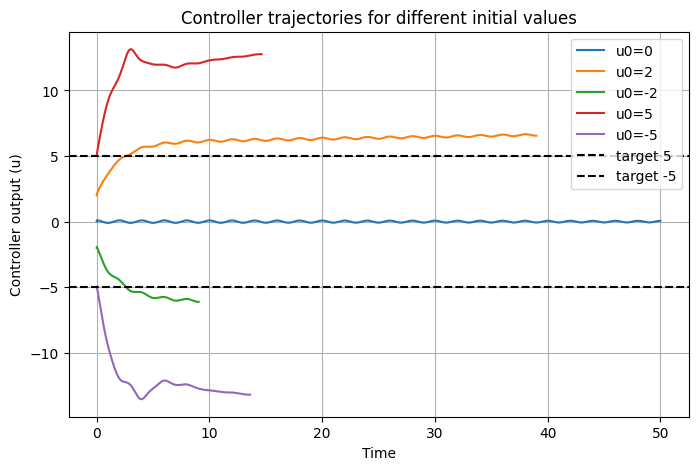

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def es_function(t, T, hpf, lpf, f, c, a_param, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, akm1, lpf_a):
    w = 2*np.pi*f

    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)
    psik = sigmak*np.cos(w*t)
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    ak = a_param * (T*lpf_a*( (np.arctan(psik) / np.pi * 2 )**2 + (np.arctan(psikm1) / np.pi * 2)**2)) - (T*lpf_a - 2)*akm1/(2 + T*lpf_a)
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)
    uk = (uhatk + ak*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk, ak)


# -------------------------
# Simulation Parameters
# -------------------------
T = 0.01  # timestep
f = 0.5 #frequency of probe, in Hz
c = 1 #gain on the integrator
lpf = 0.5 #lowpass filter critical frequency
hpf = 0.5 #highpass filter critical frequency
lpf_a = 0.01
target_value = 5   # cost function has minima at ±5
a0 = 0.1           # initial probe amplitude
epsilon = 1e-5     # convergence tolerance

# Try multiple initial conditions
initial_conditions = [0, 2, -2, 5, -5]

results = {}

print("program running...")
for u0 in initial_conditions:
    time = [0]
    u = [u0]
    J = [(u0**2 - target_value**2)**2 / 1000]
    sigma = [u0]
    psi = [u0]
    gamma = [u0]
    uhat = [u0]
    a = [a0]

    C
    time.pop()  # remove last extra timestep
    results[u0] = {"time": np.array(time), "u": np.array(u), "J": np.array(J), "a": np.array(a)}

print("program complete.")

# -------------------------
# Plot Results
# -------------------------
plt.figure(figsize=(8,5))
for u0, res in results.items():
    plt.plot(res["time"], res["u"], label=f"u0={u0}")
plt.axhline(y=target_value, color='k', linestyle='--', label=f"target {target_value}")
plt.axhline(y=-target_value, color='k', linestyle='--', label=f"target {-target_value}")
plt.title("Controller trajectories for different initial values")
plt.xlabel("Time")
plt.ylabel("Controller output (u)")
plt.legend()
plt.grid(True)
plt.show()


program running...
program complete.


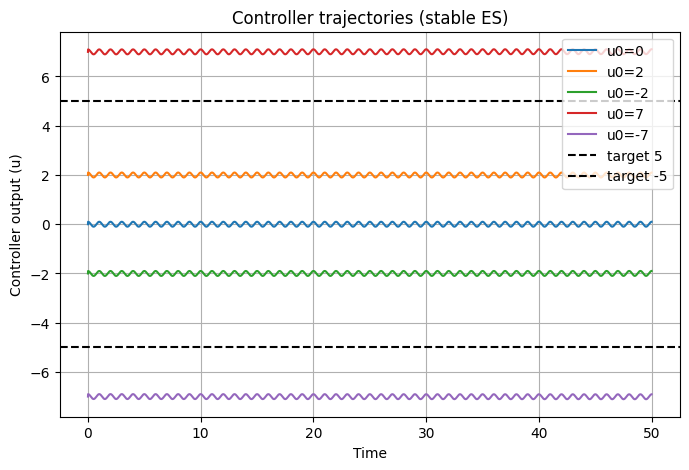

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def es_function(t, T, hpf, lpf, f, c, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, a):
    w = 2*np.pi*f

    # High-pass filter (washout)
    sigmak = (Jk - Jkm1 - (hpf*T/2-1)*sigmakm1)/(1+hpf*T/2)

    # Demodulation
    psik = sigmak*np.cos(w*t)

    # Low-pass filter
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    # Integrator
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    # Modulation (apply probing signal)
    uk = (uhatk + a*np.cos(w*t))

    return (uk, sigmak, psik, gammak, uhatk)


# -------------------------
# Simulation Parameters
# -------------------------
T = 0.01
f = 1.0
c = 0.5          # much smaller gain
lpf = 2.0
hpf = 2.0
target_value = 5
a0 = 0.1
epsilon = 1e-6

initial_conditions = [0, 2, -2, 7, -7]
results = {}

print("program running...")
for u0 in initial_conditions:
    time = [0]
    u = [u0]
    J = [((u0**2 - target_value**2)**2) / 1e5]  # scaled cost
    sigma = [0]
    psi = [0]
    gamma = [0]
    uhat = [u0]

    delta = 100
    i = 0
    while delta >= epsilon and i < 5000:
        if i >= 1:
            J.append(((u[i-1]**2 - target_value**2)**2) / 1e5)

            uk, sigmak, psik, gammak, uhatk = es_function(
                time[i], T, hpf, lpf, f, c,
                J[i], J[i-1], sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1], a0
            )

            u.append(uk)
            sigma.append(sigmak)
            psi.append(psik)
            gamma.append(gammak)
            uhat.append(uhatk)

            delta = abs(u[i] - u[i-1])

            # safety stop
            if abs(u[-1]) > 100:
                print(f"Runaway at u0={u0}, stopping early")
                break

        time.append(time[i] + T)
        i += 1

    time.pop()
    results[u0] = {"time": np.array(time), "u": np.array(u), "J": np.array(J)}

print("program complete.")

# -------------------------
# Plot Results
# -------------------------
plt.figure(figsize=(8,5))
for u0, res in results.items():
    plt.plot(res["time"], res["u"], label=f"u0={u0}")
plt.axhline(y=target_value, color='k', linestyle='--', label=f"target {target_value}")
plt.axhline(y=-target_value, color='k', linestyle='--', label=f"target {-target_value}")
plt.title("Controller trajectories (stable ES)")
plt.xlabel("Time")
plt.ylabel("Controller output (u)")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
# With updated Cost Funtion

program running...
program complete.


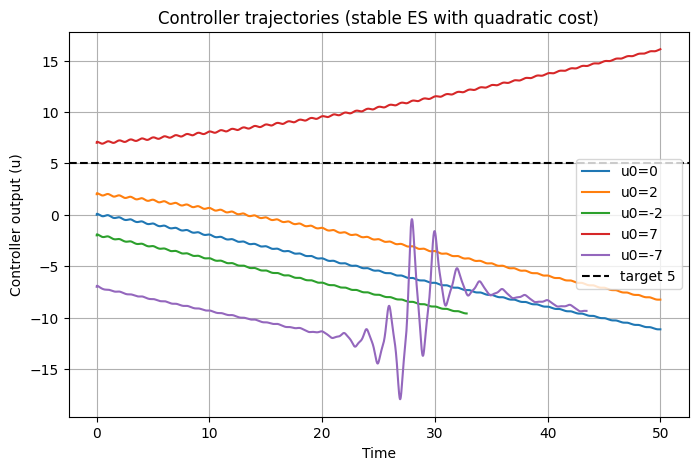

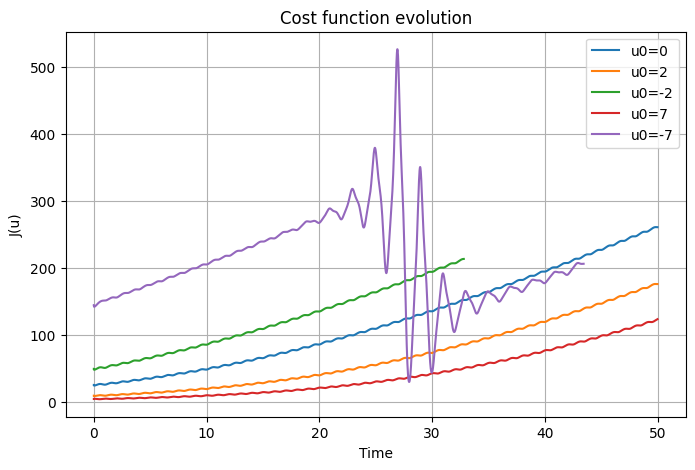

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def es_function(t, T, hpf, lpf, f, c, Jk, Jkm1, sigmakm1, psikm1, gammakm1, uhatkm1, a):
    w = 2*np.pi*f

    # High-pass filter (washout)
    sigmak = (Jk - Jkm1 - (hpf*T/2 - 1)*sigmakm1) / (1 + hpf*T/2)

    # Demodulation
    psik = sigmak * np.cos(w*t)

    # Low-pass filter
    gammak = (T*lpf*(psik + psikm1) - (T*lpf - 2)*gammakm1) / (2 + T*lpf)

    # Integrator (update estimate of optimal u)
    uhatk = uhatkm1 + c*T/2*(gammak + gammakm1)

    # Apply probing signal
    uk = uhatk + a*np.cos(w*t)

    return (uk, sigmak, psik, gammak, uhatk)

# -------------------------
# Simulation Parameters
# -------------------------
T = 0.01
f = 1.0
c = 0.5         # integrator gain
lpf = 2.0
hpf = 2.0
target_value = 5
a0 = 0.1        # probe amplitude
epsilon = 1e-6

initial_conditions = [0, 2, -2, 7, -7]
results = {}

def cost_function(u, target):
    """Quadratic cost: distance to target."""
    return (u - target)**2

print("program running...")
for u0 in initial_conditions:
    time = [0]
    u = [u0]
    J = [cost_function(u0, target_value)]   # clean definition of J
    sigma = [0]
    psi = [0]
    gamma = [0]
    uhat = [u0]

    delta = 100
    i = 0
    while delta >= epsilon and i < 5000:
        if i >= 1:
            J.append(cost_function(u[i-1], target_value))

            uk, sigmak, psik, gammak, uhatk = es_function(
                time[i], T, hpf, lpf, f, c,
                J[i], J[i-1], sigma[i-1], psi[i-1], gamma[i-1], uhat[i-1], a0
            )

            u.append(uk)
            sigma.append(sigmak)
            psi.append(psik)
            gamma.append(gammak)
            uhat.append(uhatk)

            delta = abs(u[i] - u[i-1])

            # safety stop
            if abs(u[-1]) > 100:
                print(f"Runaway at u0={u0}, stopping early")
                break

        time.append(time[i] + T)
        i += 1

    time.pop()
    results[u0] = {"time": np.array(time), "u": np.array(u), "J": np.array(J)}

print("program complete.")

# -------------------------
# Plot Results
# -------------------------
plt.figure(figsize=(8,5))
for u0, res in results.items():
    plt.plot(res["time"], res["u"], label=f"u0={u0}")
plt.axhline(y=target_value, color='k', linestyle='--', label=f"target {target_value}")
plt.title("Controller trajectories (stable ES with quadratic cost)")
plt.xlabel("Time")
plt.ylabel("Controller output (u)")
plt.legend()
plt.grid(True)
plt.show()

# Plot cost evolution
plt.figure(figsize=(8,5))
for u0, res in results.items():
    plt.plot(res["time"], res["J"], label=f"u0={u0}")
plt.title("Cost function evolution")
plt.xlabel("Time")
plt.ylabel("J(u)")
plt.legend()
plt.grid(True)
plt.show()
